In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# BTC-USD

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/BTC-USD.csv',usecols=['Date','Close'],index_col='Date',parse_dates=True)

In [ ]:
df.head()

,Close
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000


<Axes: xlabel='Date'>

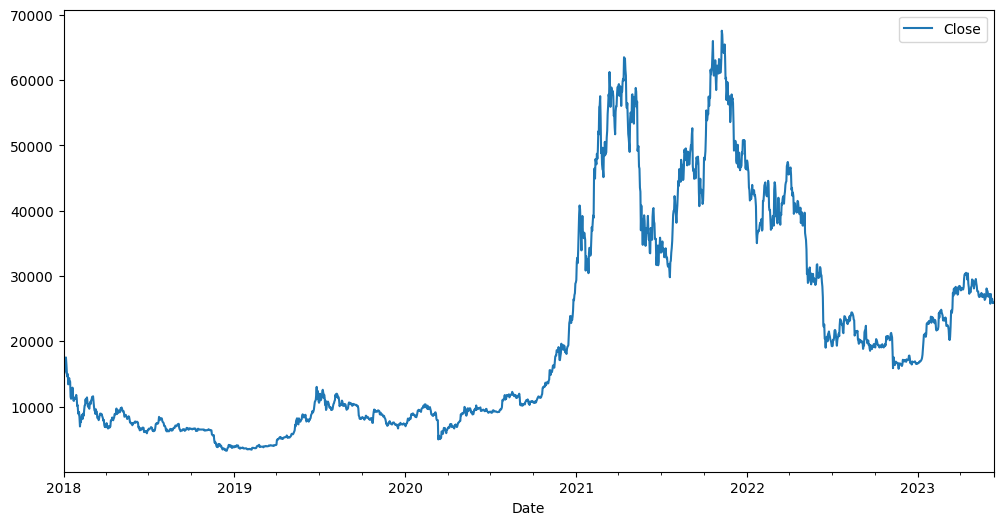

In [ ]:
df.plot(figsize=(12,6))

In [ ]:
df1 = df.reset_index()['Close']

In [ ]:
len(df1)

1989

## 7:2:1

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

In [ ]:
#Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 37ms/step - loss: 0.0305 - val_loss: 0.0022
Epoch 2/100
21/21 [==============================] - 1s 24ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 3/100
21/21 [==============================] - 0s 22ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 4/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 5/100
21/21 [==============================] - 1s 35ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/100
21/21 [==============================] - 1s 40ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 7/100
21/21 [==============================] - 1s 40ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 8/100
21/21 [==============================] - 1s 41ms/step - loss: 9.4761e-04 - val_loss: 0.0017
Epoch 9/100
21/21 [==============================] - 1s 41ms/step - loss: 9.0703e-04 - val_loss: 0.0020
Epoch 10/100
21/21 [==============================] - 1s 46ms/step - loss: 8.4006e-04 - val_

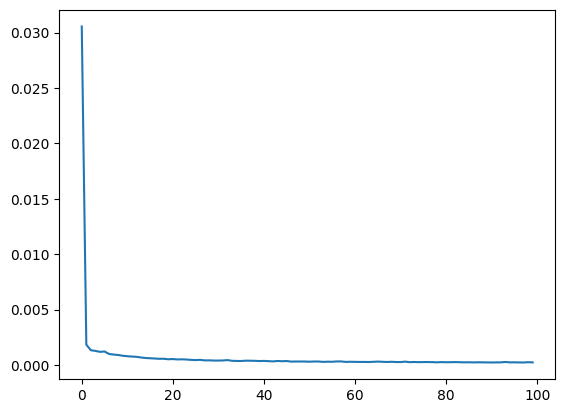

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 7ms/step


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [ ]:
y_pred.shape

(296, 1)

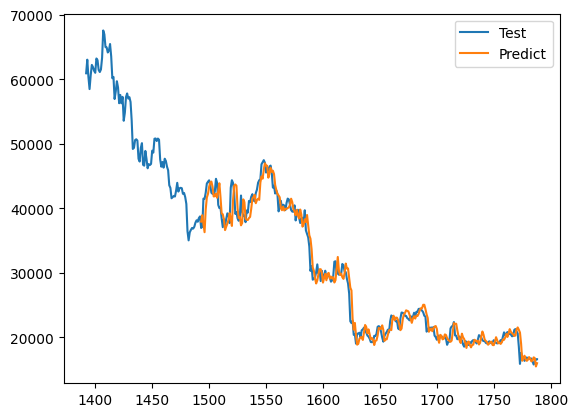

In [ ]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

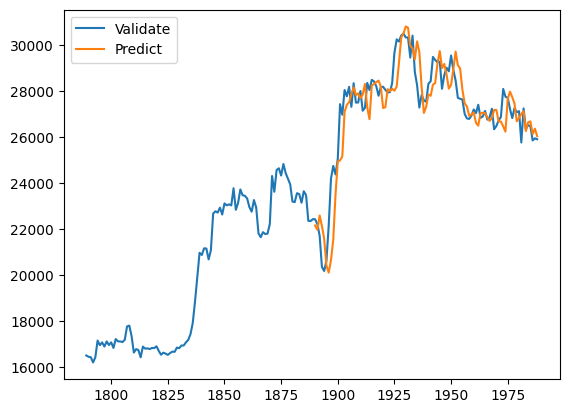

In [ ]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','Predict'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 7345201.108080384
MAE: 27163.385022854454
RMSE: 27252.672923837377
--------------------------
---------TEST----------
MAPE: 8324040.347846222
MAE: 28246.289992953818
RMSE: 29795.142153790268
-------------------


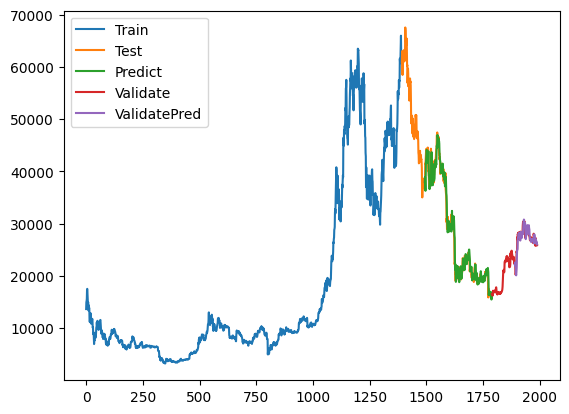

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [ ]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [ ]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [ ]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1], 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1], 1)

In [ ]:
#Define LSTM Model
model1 = Sequential()
model1.add(SimpleRNN(50, input_shape=(time_step, 1)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 43ms/step - loss: 0.0032 - val_loss: 0.2631
Epoch 2/100
14/14 [==============================] - 0s 27ms/step - loss: 2.8608e-04 - val_loss: 0.1617
Epoch 3/100
14/14 [==============================] - 0s 27ms/step - loss: 1.7356e-04 - val_loss: 0.1400
Epoch 4/100
14/14 [==============================] - 0s 26ms/step - loss: 1.5573e-04 - val_loss: 0.1391
Epoch 5/100
14/14 [==============================] - 0s 26ms/step - loss: 1.3914e-04 - val_loss: 0.1270
Epoch 6/100
14/14 [==============================] - 0s 27ms/step - loss: 1.2966e-04 - val_loss: 0.1198
Epoch 7/100
14/14 [==============================] - 1s 43ms/step - loss: 1.1912e-04 - val_loss: 0.1126
Epoch 8/100
14/14 [==============================] - 1s 52ms/step - loss: 1.1263e-04 - val_loss: 0.1057
Epoch 9/100
14/14 [==============================] - 1s 45ms/step - loss: 1.0501e-04 - val_loss: 0.1007
Epoch 10/100
14/14 [==============================] - 0s 26ms/step -

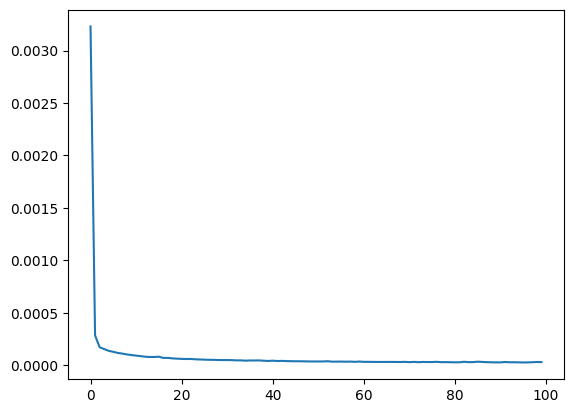

In [ ]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 7ms/step


In [ ]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

In [ ]:
test_data.shape

(397, 1)

In [ ]:
y_pred1.shape

(495, 1)

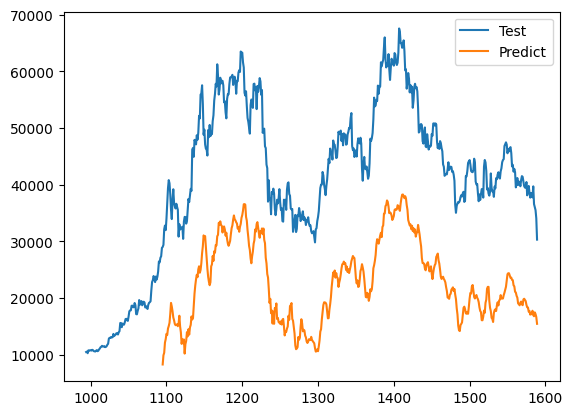

In [ ]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [ ]:
val_data1.shape

(399, 1)

In [ ]:
y_pred_val1.shape

(298, 1)

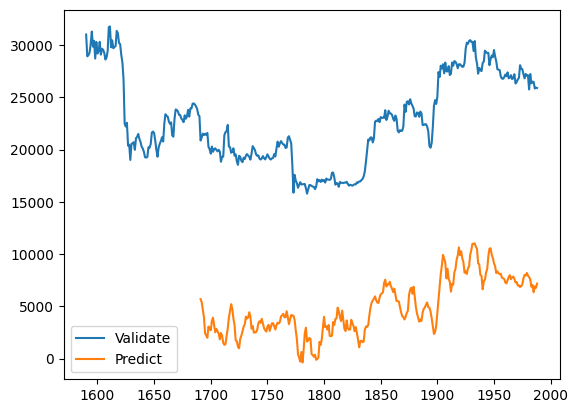

In [ ]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','Predict'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 1756073.005974146
MAE: 4926.879381487197
RMSE: 5606.482937549261
--------------------------
---------TEST----------
MAPE: 3643975.9149305727
MAE: 23003.803064129646
RMSE: 24093.38129177129
-------------------


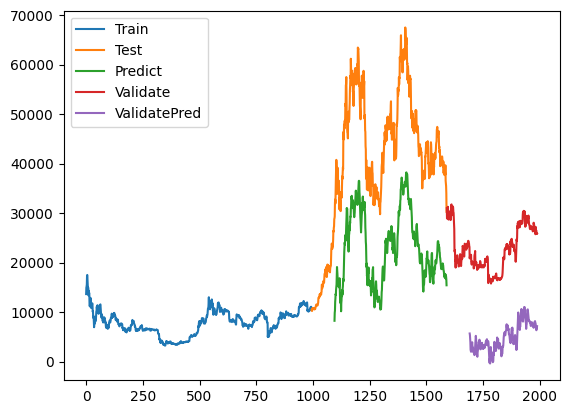

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

# DOGE-USD

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/DOGE-USD.csv',usecols=['Date','Close'],index_col='Date',parse_dates=True)

In [ ]:
df.head()

,Close
Date,
2018-01-01,0.008909
2018-01-02,0.009145
2018-01-03,0.009320
2018-01-04,0.009644
2018-01-05,0.012167


<Axes: xlabel='Date'>

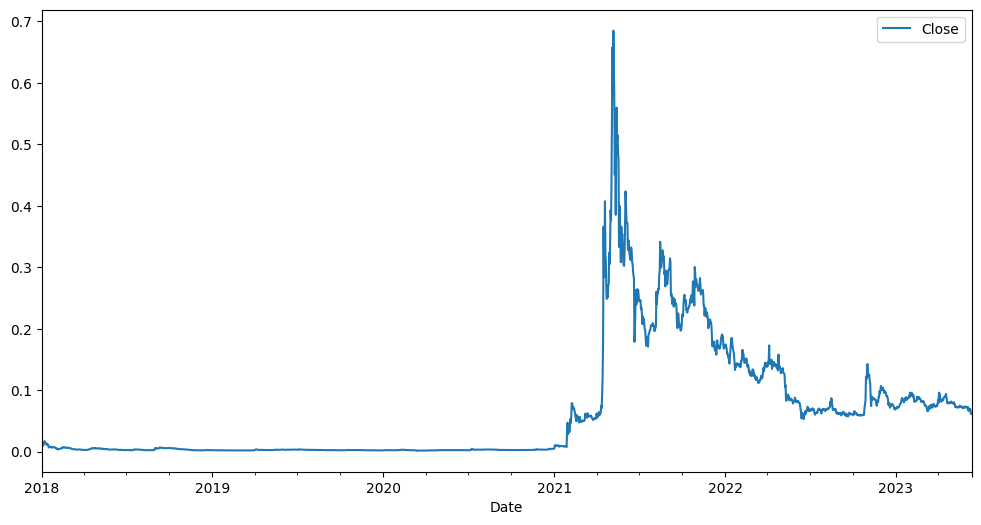

In [ ]:
df.plot(figsize=(12,6))

In [ ]:
df1 = df.reset_index()['Close']

In [ ]:
len(df1)

1989

## 7:2:1

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

In [ ]:
#Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 33ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 2/100
21/21 [==============================] - 1s 24ms/step - loss: 0.0011 - val_loss: 3.7071e-04
Epoch 3/100
21/21 [==============================] - 1s 25ms/step - loss: 7.5920e-04 - val_loss: 7.6716e-04
Epoch 4/100
21/21 [==============================] - 1s 26ms/step - loss: 6.8451e-04 - val_loss: 3.4861e-04
Epoch 5/100
21/21 [==============================] - 1s 41ms/step - loss: 6.1342e-04 - val_loss: 3.5300e-04
Epoch 6/100
21/21 [==============================] - 1s 41ms/step - loss: 5.9161e-04 - val_loss: 2.7933e-04
Epoch 7/100
21/21 [==============================] - 1s 42ms/step - loss: 5.2051e-04 - val_loss: 3.8663e-04
Epoch 8/100
21/21 [==============================] - 1s 43ms/step - loss: 5.1240e-04 - val_loss: 1.7274e-04
Epoch 9/100
21/21 [==============================] - 1s 41ms/step - loss: 4.7490e-04 - val_loss: 4.8316e-04
Epoch 10/100
21/21 [====================

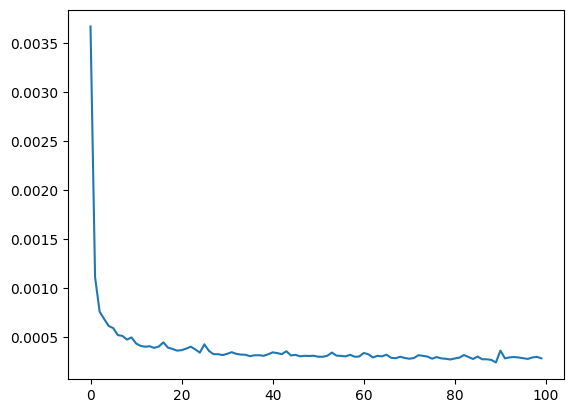

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 7ms/step


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

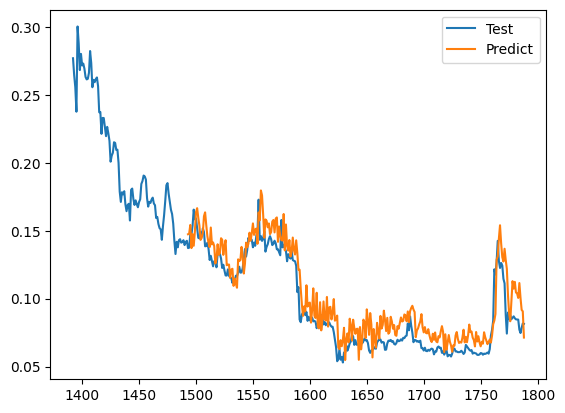

In [ ]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

In [ ]:
print(val_data.shape)
print(y_pred_val.shape)

(200, 1)
(99, 1)


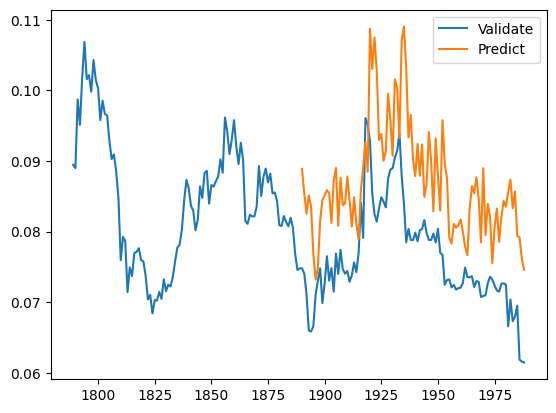

In [ ]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','Predict'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 20.4460393766144
MAE: 0.023053605910502258
RMSE: 0.026008559999839583
--------------------------
---------TEST----------
MAPE: 36.09715589732815
MAE: 0.05228553108972824
RMSE: 0.06609670359131993
-------------------


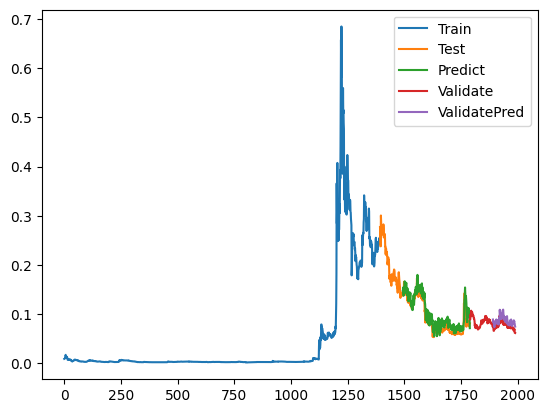

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [ ]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [ ]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [ ]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1], 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1], 1)

In [ ]:
#Define LSTM Model
model1 = Sequential()
model1.add(SimpleRNN(50, input_shape=(time_step, 1)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 42ms/step - loss: 4.6790e-05 - val_loss: 0.0598
Epoch 2/100
14/14 [==============================] - 0s 32ms/step - loss: 8.2688e-06 - val_loss: 0.0630
Epoch 3/100
14/14 [==============================] - 1s 46ms/step - loss: 2.8494e-06 - val_loss: 0.0615
Epoch 4/100
14/14 [==============================] - 1s 47ms/step - loss: 1.6662e-06 - val_loss: 0.0580
Epoch 5/100
14/14 [==============================] - 1s 47ms/step - loss: 1.3082e-06 - val_loss: 0.0539
Epoch 6/100
14/14 [==============================] - 1s 48ms/step - loss: 1.1517e-06 - val_loss: 0.0500
Epoch 7/100
14/14 [==============================] - 1s 51ms/step - loss: 1.0980e-06 - val_loss: 0.0459
Epoch 8/100
14/14 [==============================] - 1s 46ms/step - loss: 9.9765e-07 - val_loss: 0.0422
Epoch 9/100
14/14 [==============================] - 1s 43ms/step - loss: 9.4248e-07 - val_loss: 0.0382
Epoch 10/100
14/14 [==============================] - 0s 31ms/st

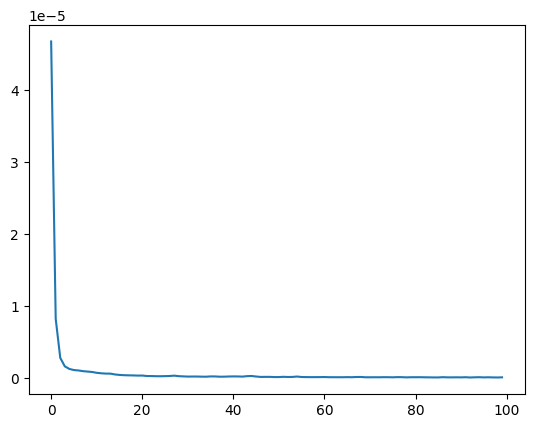

In [ ]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 9ms/step


In [ ]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

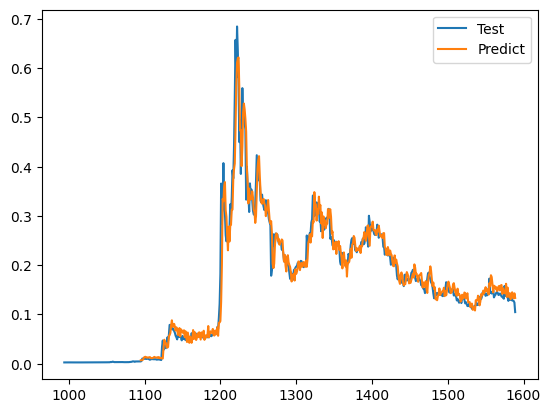

In [ ]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [ ]:
print(val_data1.shape)
print(y_pred_val1.shape)

(399, 1)
(298, 1)


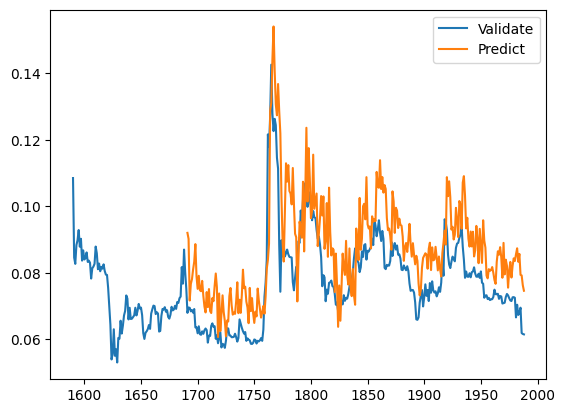

In [ ]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','Predict'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 23.364539911910864
MAE: 0.027961363475917465
RMSE: 0.03494978315130757
--------------------------
---------TEST----------
MAPE: 170.7778855324587
MAE: 0.16637061606234146
RMSE: 0.21523566459635088
-------------------


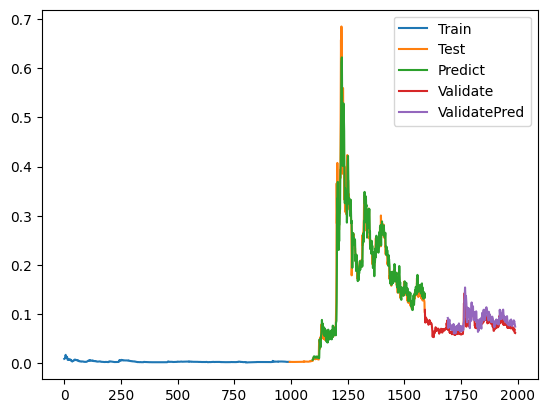

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

# ETH-USD

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/ETH-USD.csv',usecols=['Date','Close'],index_col='Date')

In [ ]:
df

,Close
Date,
2018-01-01,772.640991
2018-01-02,884.443970
2018-01-03,962.719971
2018-01-04,980.921997
2018-01-05,997.719971
...,...
2023-06-08,1846.301880
2023-06-09,1840.225220
2023-06-10,1752.384766


<Axes: xlabel='Date'>

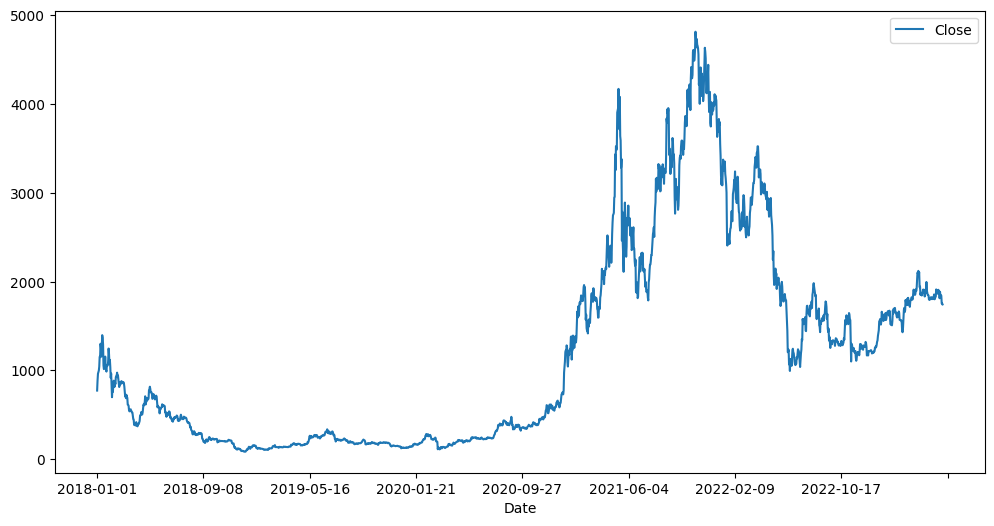

In [ ]:
df.plot(figsize=(12,6))

In [ ]:
df1 = df.reset_index()['Close']

In [ ]:
df1

0        772.640991
1        884.443970
2        962.719971
3        980.921997
4        997.719971
           ...     
1984    1846.301880
1985    1840.225220
1986    1752.384766
1987    1753.415283
1988    1742.528687
Name: Close, Length: 1989, dtype: float64

In [ ]:
len(df1)

1989

## 7:2:1

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

In [ ]:
#Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 3s 59ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 2/100
21/21 [==============================] - 1s 42ms/step - loss: 7.5150e-04 - val_loss: 0.0015
Epoch 3/100
21/21 [==============================] - 0s 23ms/step - loss: 6.3461e-04 - val_loss: 0.0010
Epoch 4/100
21/21 [==============================] - 0s 23ms/step - loss: 6.4124e-04 - val_loss: 0.0011
Epoch 5/100
21/21 [==============================] - 0s 23ms/step - loss: 6.4509e-04 - val_loss: 0.0018
Epoch 6/100
21/21 [==============================] - 0s 23ms/step - loss: 5.4137e-04 - val_loss: 0.0011
Epoch 7/100
21/21 [==============================] - 0s 23ms/step - loss: 5.1552e-04 - val_loss: 9.6602e-04
Epoch 8/100
21/21 [==============================] - 0s 23ms/step - loss: 5.5049e-04 - val_loss: 8.3125e-04
Epoch 9/100
21/21 [==============================] - 0s 22ms/step - loss: 4.9691e-04 - val_loss: 0.0012
Epoch 10/100
21/21 [==============================] - 0s 24m

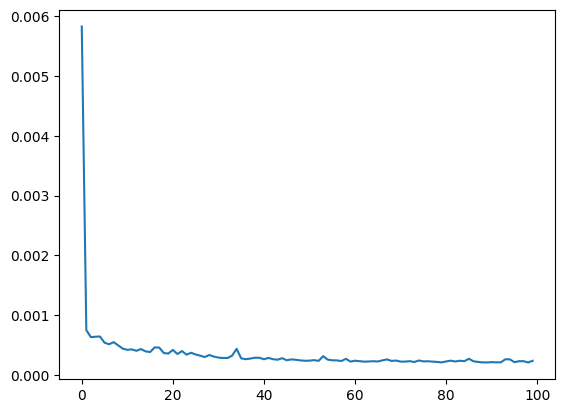

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 10ms/step


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

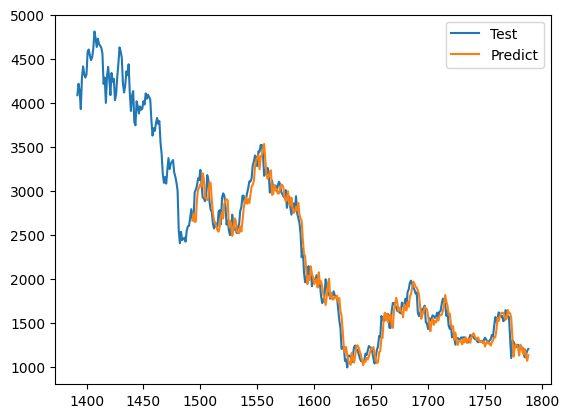

In [ ]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

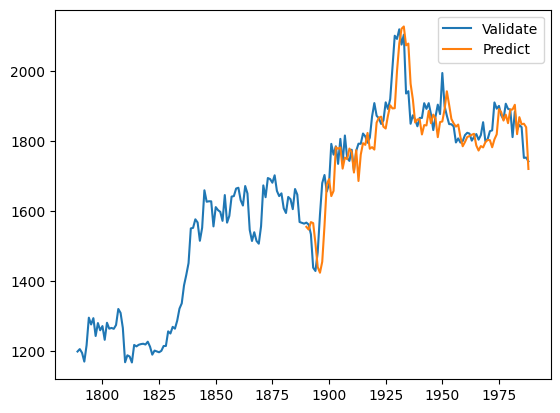

In [ ]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','Predict'])
plt.show()

In [ ]:
print(val_data.shape)
print(y_pred_val.shape)

(200, 1)
(99, 1)


In [ ]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 494547.4496052471
MAE: 1808.933353273646
RMSE: 1813.4125593045387
--------------------------
---------TEST----------
MAPE: 564425.3508994282
MAE: 1960.9783616503908
RMSE: 2088.4093584153393
-------------------


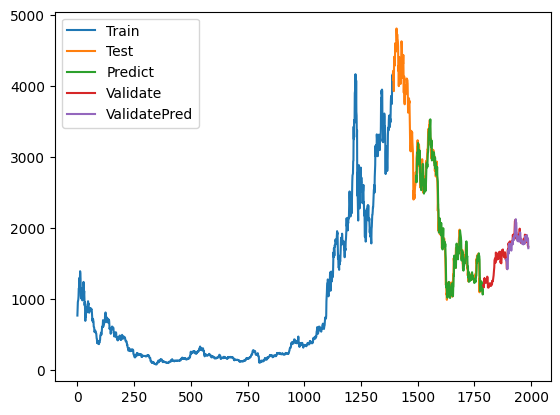

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [ ]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [ ]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [ ]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1], 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1], 1)

In [ ]:
#Define LSTM Model
model1 = Sequential()
model1.add(SimpleRNN(50, input_shape=(time_step, 1)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 61ms/step - loss: 0.0013 - val_loss: 0.3398
Epoch 2/100
14/14 [==============================] - 0s 28ms/step - loss: 4.3554e-04 - val_loss: 0.2399
Epoch 3/100
14/14 [==============================] - 0s 26ms/step - loss: 2.5615e-04 - val_loss: 0.1534
Epoch 4/100
14/14 [==============================] - 0s 27ms/step - loss: 1.5959e-04 - val_loss: 0.0927
Epoch 5/100
14/14 [==============================] - 0s 27ms/step - loss: 9.7044e-05 - val_loss: 0.0575
Epoch 6/100
14/14 [==============================] - 0s 27ms/step - loss: 6.8031e-05 - val_loss: 0.0382
Epoch 7/100
14/14 [==============================] - 0s 26ms/step - loss: 5.4480e-05 - val_loss: 0.0312
Epoch 8/100
14/14 [==============================] - 0s 26ms/step - loss: 5.1592e-05 - val_loss: 0.0278
Epoch 9/100
14/14 [==============================] - 0s 27ms/step - loss: 4.9449e-05 - val_loss: 0.0274
Epoch 10/100
14/14 [==============================] - 0s 25ms/step -

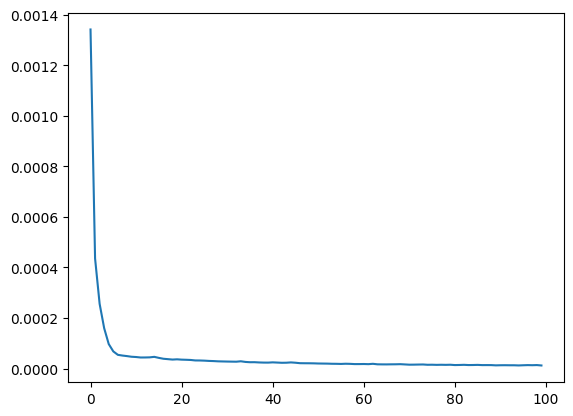

In [ ]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 6ms/step


In [ ]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

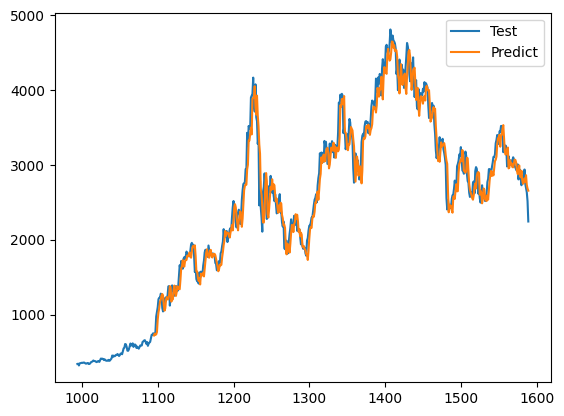

In [ ]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [ ]:
print(val_data1.shape)
print(y_pred_val1.shape)

(399, 1)
(298, 1)


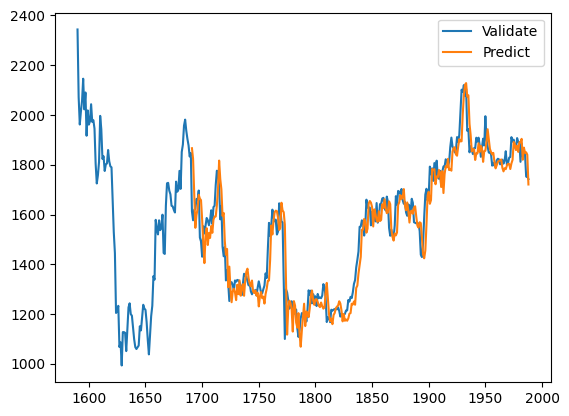

In [ ]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','Predict'])
plt.show()

In [ ]:
ytest1.shape

(495,)

In [ ]:
y_pred1.shape

(495, 1)

In [ ]:
# Using the mean_absolute_percentage_error function
from sklearn.metrics import mean_absolute_percentage_error

error = mean_absolute_percentage_error(ytest1, y_pred1)
error

4844.548663206139

In [ ]:
print('---------VALIDATE----------')

def mean_absolute_percentage_error(y_true, y_pred):
    common_length = min(len(y_true), len(y_pred))
    errors = np.abs(y_true[:common_length] - y_pred[:common_length]) / y_true[:common_length] * 100
    mape = np.mean(errors)
    return mape

valid_mape1 = mean_absolute_percentage_error(yval1,y_pred_val1)
# valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 510911.770596076
MAE: 1547.144033437801
RMSE: 1567.2652123764406
--------------------------
---------TEST----------
MAPE: 554789.050481918
MAE: 2781.5500758577255
RMSE: 2919.9430542340424
-------------------


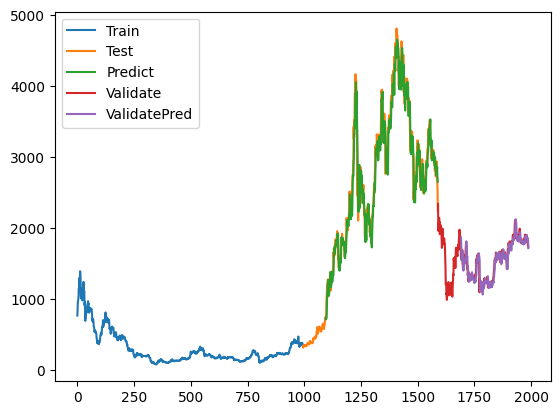

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()